# PhotoMatching Project

Мне было поручено разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from transformers import BertModel, BertTokenizer

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# ImageOpening Module
from PIL import Image
import os

sns.set_style('darkgrid')
np.random.seed(333)

/Users/daniilkorolev/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Исследовательский анализ данных

### Эксперты

In [2]:
col_names = ['image', 'query_id', 'Expert_1', 'Expert_2', 'Expert_3']
experts_data = pd.read_table('/Users/daniilkorolev/Jupyter Notebook Projects/data/Photo Matching Data/ExpertAnnotations.tsv',
                             header=None,
                             names=col_names)

new_rates = {1: 0, 2: 0.3, 3: 0.6, 4: 1}

experts_data['Expert_1'] = experts_data['Expert_1'].replace(new_rates)
experts_data['Expert_2'] = experts_data['Expert_2'].replace(new_rates)
experts_data['Expert_3'] = experts_data['Expert_3'].replace(new_rates)


experts_data

,image,query_id,Expert_1,Expert_2,Expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.0,0.0,0.3
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.0,0.0,0.3
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.0,0.3,0.3
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.0,0.0,0.3
...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.0,0.0,0.0
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.0,0.0,0.0
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.0,0.0,0.3
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.0,0.0,0.0


In [3]:
def get_consensus(row):
    
    experts_score = [row['Expert_1'], row['Expert_2'], row['Expert_3']]
    score_counts = pd.Series(experts_score).value_counts()
    
    for score, count in score_counts.items():
        if count >= 2:
            return score
        return None
    
experts_data['score'] = experts_data.apply(get_consensus, axis=1)

experts_data = experts_data.dropna()
experts_data

,image,query_id,Expert_1,Expert_2,Expert_3,score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.0,0.0,0.3,0.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.0,0.0,0.3,0.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.0,0.3,0.3,0.3
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.0,0.0,0.3,0.0
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.0,0.0,0.0,0.0
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.0,0.0,0.0,0.0
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.0,0.0,0.3,0.0
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.0,0.0,0.0,0.0


Для удобства последующей обработки было решено преобразовать оценки экспертов

In [4]:
experts_data.describe()

,Expert_1,Expert_2,Expert_3,score
count,5696.000000,5696.000000,5696.000000,5696.000000
mean,0.136850,0.188904,0.262465,0.188904
std,0.252244,0.273436,0.283783,0.273436
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.300000,0.000000
75%,0.300000,0.300000,0.300000,0.300000
max,1.000000,1.000000,1.000000,1.000000


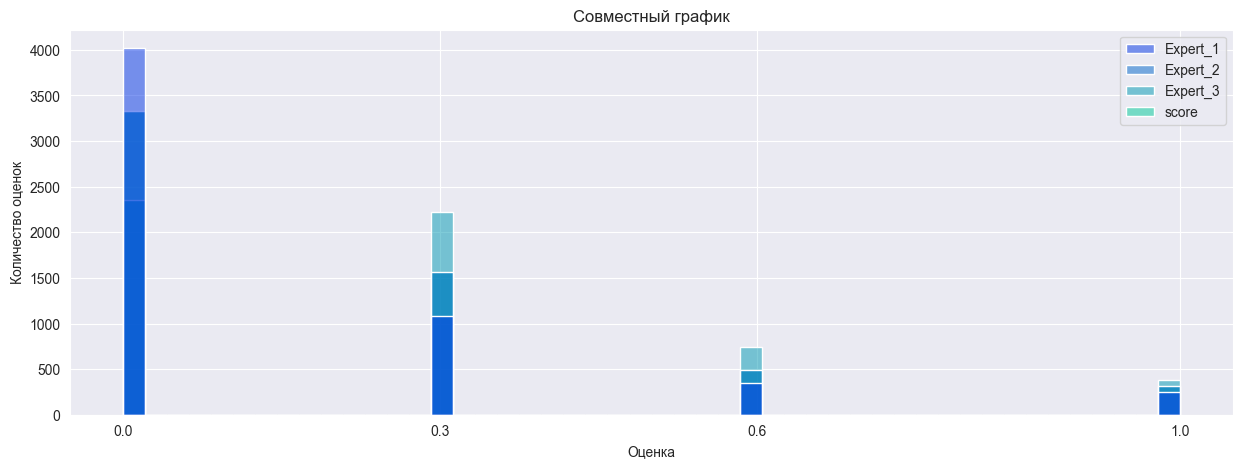

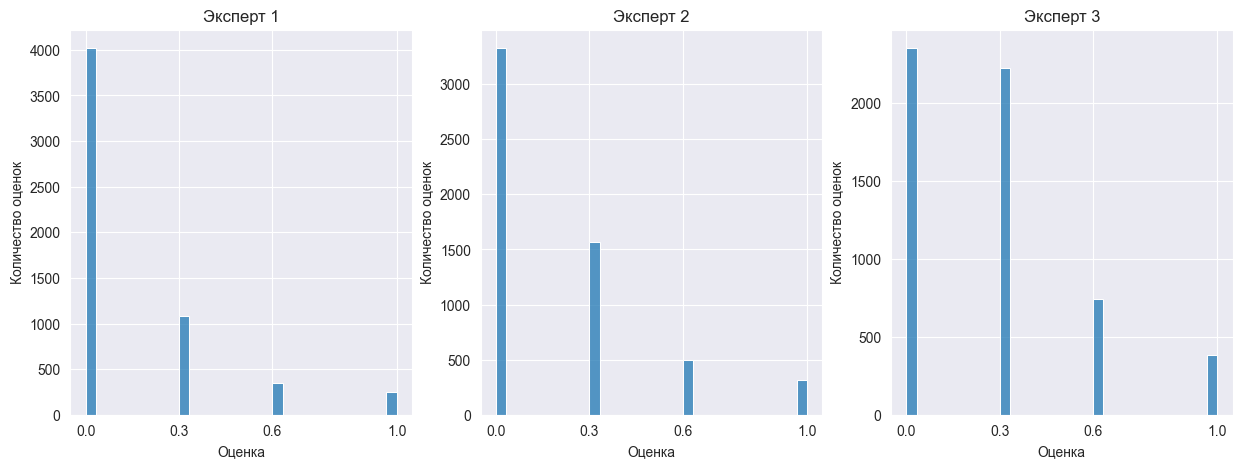

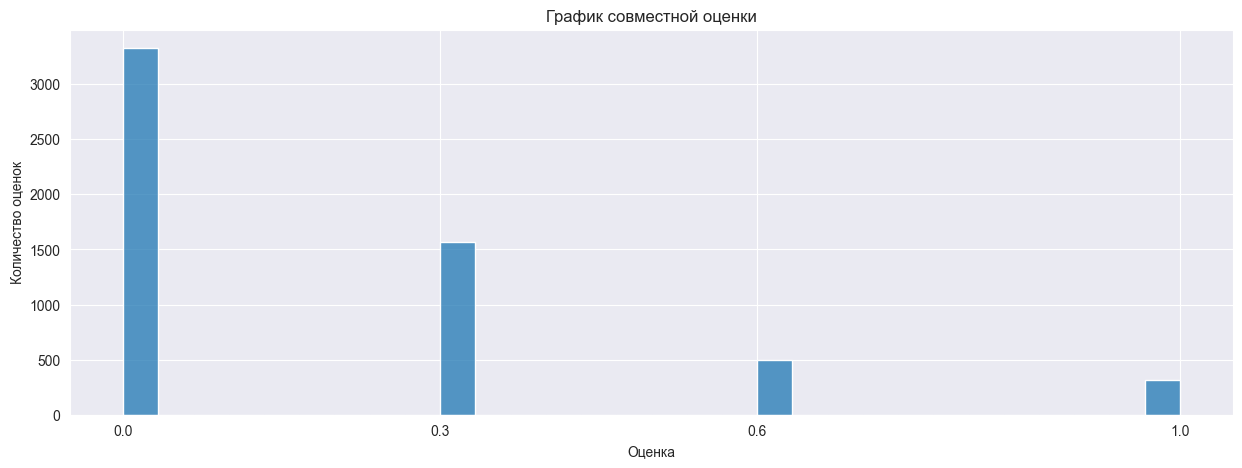

In [5]:
plt.figure(figsize=(15, 5))
plt.title('Совместный график')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.histplot(experts_data, palette='winter')
plt.xticks([0, 0.3, 0.6, 1])

plt.show()


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Эксперт 1')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.histplot(experts_data['Expert_1'])
plt.xticks([0, 0.3, 0.6, 1])

plt.subplot(1, 3, 2)
plt.title('Эксперт 2')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.histplot(experts_data['Expert_2'])
plt.xticks([0, 0.3, 0.6, 1])

plt.subplot(1, 3, 3)
plt.title('Эксперт 3')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.histplot(experts_data['Expert_3'])
plt.xticks([0, 0.3, 0.6, 1])

plt.show()

plt.figure(figsize=(15, 5))
plt.title('График совместной оценки')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.histplot(experts_data['score'])
plt.xticks([0, 0.3, 0.6, 1])

plt.show()

**Вывод по блоку**

Видно что эксперты по разному ставят оценки, у первого эксперта видимо были очень жесткие требования к точности запросов.

Функцией `get_consensus` была получена итоговая оценка экспертов по каждой паре

### Толпа

In [6]:
col_names = ['image', 'query_id', 'crowd_score', 'Yes', 'No']
crowd_data = pd.read_table('/Users/daniilkorolev/Jupyter Notebook Projects/data/Photo Matching Data/CrowdAnnotations.tsv',
                           header=None,
                           names=col_names)
print(crowd_data.describe())
print(crowd_data['crowd_score'].unique())
crowd_data

        crowd_score           Yes            No
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000
[1.         0.         0.33333333 0.66666667 0.25       0.6
 0.2        0.5        0.4        0.75       0.16666667 0.8       ]


,image,query_id,crowd_score,Yes,No
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3


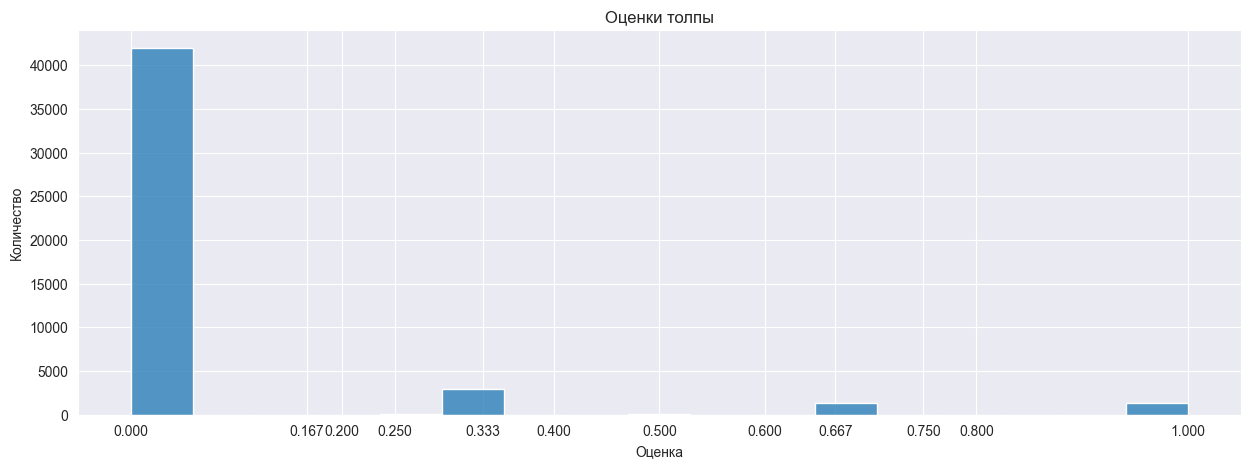

In [7]:
plt.figure(figsize=(15, 5))
plt.title('Оценки толпы')
plt.xlabel('Оценка')
plt.ylabel('Количество')
sns.histplot(crowd_data['crowd_score'])
plt.xticks(crowd_data['crowd_score'].unique())

plt.show()

**Вывод по блоку**

Получен датасет с оценками различных комбинаций описаний и картинок

### Подготовка тренировочного датасета

In [8]:
train_data = pd.read_csv('/Users/daniilkorolev/Jupyter Notebook Projects/data/Photo Matching Data/train_dataset.csv')

train_data

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


In [9]:
query = train_data[['query_id', 'query_text']].drop_duplicates()
query[query['query_id'] == '543007912_23fc735b99.jpg#2']

,query_id,query_text
571,543007912_23fc735b99.jpg#2,Two girls with orange shirts .


In [10]:
train = pd.merge(crowd_data, train_data, left_on=['image', 'query_id'], right_on=['image', 'query_id'], how='left')
train = pd.merge(train, experts_data, left_on=['image', 'query_id'], right_on=['image', 'query_id'], how='left')
train = pd.merge(train, query, on='query_id', how='left', suffixes=('', '_from_train'))
train['query_text'] = train['query_text'].combine_first(train['query_text_from_train'])
train.drop(columns=['query_text_from_train'], inplace=True)
train

,image,query_id,crowd_score,Yes,No,query_text,Expert_1,Expert_2,Expert_3,score
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0,"A woman is signaling is to traffic , as seen f...",NaN,NaN,NaN,NaN
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3,A boy in glasses is wearing a red shirt .,NaN,NaN,NaN,NaN
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3,A young boy holds onto a blue handle on a pier .,NaN,NaN,NaN,NaN
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3,"A woman wearing black clothes , a purple scarf...",NaN,NaN,NaN,NaN
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3,An older woman with blond hair rides a bicycle...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3,Two girls with orange shirts .,NaN,NaN,NaN,NaN
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2,A woman in jeans rock climbing .,NaN,NaN,NaN,NaN
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0,A man is climbing the side of a mountain .,NaN,NaN,NaN,NaN
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3,A person flipping upside down,NaN,NaN,NaN,NaN


In [11]:
train = train[['image', 'query_id', 'crowd_score', 'query_text', 'score']]
train

,image,query_id,crowd_score,query_text,score
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,"A woman is signaling is to traffic , as seen f...",NaN
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,A boy in glasses is wearing a red shirt .,NaN
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,A young boy holds onto a blue handle on a pier .,NaN
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,"A woman wearing black clothes , a purple scarf...",NaN
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,An older woman with blond hair rides a bicycle...,NaN
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,Two girls with orange shirts .,NaN
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,A woman in jeans rock climbing .,NaN
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,A man is climbing the side of a mountain .,NaN
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,A person flipping upside down,NaN


In [12]:
def train_scorer(row):
    if row['score'] >= 0:
        row['score'] = (row['score'] * 0.6) + (row['crowd_score'] * 0.4)
    else:
        row['score'] = row['crowd_score']
    return row
        
train = train.apply(train_scorer, axis=1)
train = train.dropna()

In [13]:
train

,image,query_id,crowd_score,query_text,score
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,"A woman is signaling is to traffic , as seen f...",1.000000
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,A boy in glasses is wearing a red shirt .,0.000000
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,A young boy holds onto a blue handle on a pier .,0.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,"A woman wearing black clothes , a purple scarf...",0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,An older woman with blond hair rides a bicycle...,0.000000
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,Two girls with orange shirts .,0.000000
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,A woman in jeans rock climbing .,0.333333
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,A man is climbing the side of a mountain .,1.000000
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,A person flipping upside down,0.000000


In [14]:
train['score'].value_counts()

score
0.000000    39947
0.333333     2719
1.000000     1268
0.666667     1195
0.180000      805
0.360000      179
0.493333      142
0.250000       89
0.313333       79
0.626667       73
0.866667       62
0.760000       35
0.500000       23
0.200000       20
0.446667       18
0.733333       18
0.600000        8
0.750000        7
0.400000        6
0.133333        4
0.166667        3
0.560000        2
0.260000        2
0.520000        2
0.460000        2
0.580000        2
0.800000        2
0.380000        2
0.680000        2
0.280000        2
0.660000        2
0.100000        1
Name: count, dtype: int64

Видна огромная разница в количестве нулевых значений и всех других

**Вывод по блоку**

Получен большой датасет сформированный по такому принципу - поэтапно соединены датасеты `crowd_data + train_data + experts_data` в итоге был получен комбинированный датасет `train`, далее были дополнены пропущенные тексты описаний и вычислена итоговая оценка по комбинации изображения и описания как оценка толпы (если нет оценки экспертов) и оценка экспертов с весом 0.6 и оценка топлы с весом 0.4

### Модуль цензуры

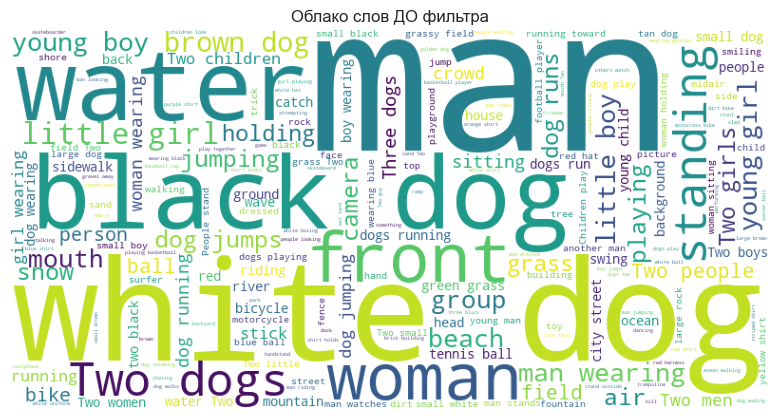

In [15]:
df = train
corpus = ' '.join(df['query_text'].astype(str).values)

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(corpus)



plt.figure(figsize = (8, 4), facecolor = None)
plt.title('Облако слов ДО фильтра')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [16]:
stop_law = ['boy', 'boys', 'girl', 'girls', 'teen', 'teens', 'child', 'children', 'toddler', 'young']

def censoring(line, stop_law, column=None):
    for word in stop_law:
        if word in line:
            return None
    return line

train['query_text'] = train['query_text'].apply(lambda x: censoring(x, stop_law))#, 'query_text'))
train = train.dropna()

In [17]:
train

,image,query_id,crowd_score,query_text,score
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,"A woman is signaling is to traffic , as seen f...",1.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,"A woman wearing black clothes , a purple scarf...",0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,An older woman with blond hair rides a bicycle...,0.000000
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,A woman wearing a white glove peers over the c...,0.000000
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,A man taking a picture with a silver camera .,0.000000
...,...,...,...,...,...
47824,997722733_0cb5439472.jpg,486917990_72bd4069af.jpg#2,0.333333,A person wearing a white hat climbs a rock .,0.493333
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,A woman in jeans rock climbing .,0.333333
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,A man is climbing the side of a mountain .,1.000000
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,A person flipping upside down,0.000000


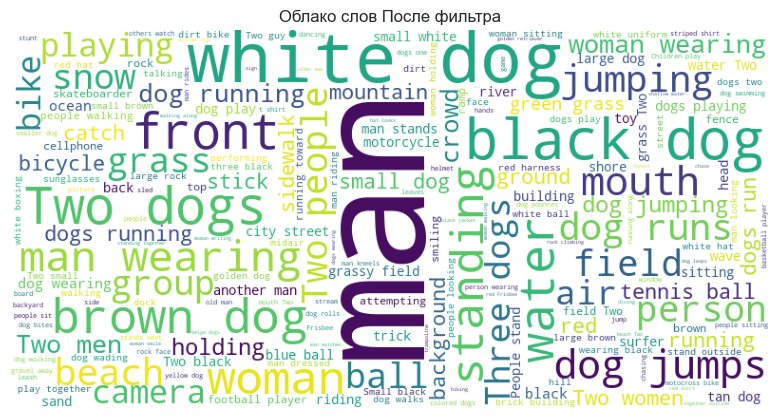

In [18]:
df = train
corpus = ' '.join(df['query_text'].astype(str).values)

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(corpus)



plt.figure(figsize = (8, 4), facecolor = None)
plt.title('Облако слов После фильтра')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

**Вывод**

Цензура сработала как нужно и теперь нет нежелательных описаний в тренировочных данных
Для наглядности работы цензуры были построены 2 графика облака слов ДО и ПОСЛЕ проверки данных цензурным модулем

## Получение эмбеддингов

### Эмбеддинги изображений

In [19]:
rep = None

def get_image_embeddings(image_paths):
    # пустой список для эмбеддингов
    embeddings = []
    #загрузчик данных
    loader = DataLoader(image_paths, batch_size=1, shuffle=True)
    
    # моделька ResNet18
    resnet = models.resnet18(pretrained=True)
    for params in resnet.parameters():
        params.requires_grad_(False)
        
    #испольщование только светочных слоев
    modules = list(resnet.children())[:-1]
    resnet = nn.Sequential(*modules)
    resnet.eval()
    
    #подготовительное преобразование
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm
    ])
    
    #формирование батчей
    for batch in tqdm(loader):
        batch_images = []
        for path in batch:
            img = Image.open(path).convert('RGB')
            image_tensor = preprocess(img)
            batch_images.append(image_tensor)
            
        batch_images = torch.stack(batch_images)
        
        #преобразование батча в эмбеддинги
        with torch.no_grad():
            batch_embeddings = resnet(batch_images)#.squeeze() вернуть при возобновлении обучения по батчам
        for emb in batch_embeddings:
            embeddings.append(emb.flatten().cpu().numpy())
        
    return np.array(embeddings)

def get_text_embeddings(queries):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    embeddings = []
    for query in tqdm(queries):
        inputs = tokenizer(query, return_tensors='pt', truncation=True, padding=True, max_length=128)
        outputs = bert_model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        embedding = last_hidden_state[:, 0, :].detach().numpy()
        embeddings.append(embedding.flatten())
    return np.array(embeddings)

def combine_embeddings(img_embeddings, text_embeddings):
    combined_embeddings = np.concatenate([img_embeddings, text_embeddings], axis=1)
    return combined_embeddings

# Пример вызова функций
image_paths = ['/Users/daniilkorolev/Jupyter Notebook Projects/data/Photo Matching Data/train_images/'\
               + image_name for image_name in train['image']]
img_embeddings = get_image_embeddings(image_paths[:rep]) #Не забыть вернуть при отладке
queries = train['query_text'].to_list()
text_queries = queries  # Ваши текстовые данные здесь
text_embeddings = get_text_embeddings(text_queries[:rep]) #Не забыть вернуть при отладке


print(f"Размерность эмбеддингов изображений: {img_embeddings.shape}")  # Ожидаем (34027, 512)
print(f"Размерность эмбеддингов текста: {text_embeddings.shape}")  # Ожидаем (34027, 768)
# Убедимся, что количество эмбеддингов совпадает
#assert len(img_embeddings) == len(text_embeddings), "Количество изображений и текстов должно совпадать!"

# Проверим размерности эмбеддингов до объединения


# Объединим эмбеддинги
combined_embeddings = combine_embeddings(img_embeddings, text_embeddings)
print(f"Размерность объединённых эмбеддингов: {combined_embeddings.shape}")  # Ожидаем (34027, 1280)


/Users/daniilkorolev/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/daniilkorolev/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████| 34027/34027 [16:13<00:00, 34.95it/s]

Размерность эмбеддингов изображений: (34027, 512)
Размерность эмбеддингов текста: (34027, 768)
Размерность объединённых эмбеддингов: (34027, 1280)


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error

combined_embeddings = pd.DataFrame(combined_embeddings)
train_data = combined_embeddings
train_data['target'] = train['score'].values[:rep]

train_data['group'] = np.where(np.random.rand(len(train_data)) < 0.3, 1, 0)
train_data[:] # изменить тут

# majority_class = train_data[train_data['target']==0]
# minority_class = train_data[train_data['target']!=0]

# downsampled = majority_class.sample(len(minority_class), random_state=333)

# train_data = pd.concat([downsampled, minority_class]).reset_index(drop=True)
# train_data = pd.DataFrame(train_data)
# train_data

,0,1,2,3,4,5,6,7,8,9,...,1272,1273,1274,1275,1276,1277,1278,1279,target,group
0,0.087212,1.473425,1.110406,0.000000,0.617307,2.179602,0.814188,2.273701,1.780632,4.455775,...,-0.168586,0.175085,-0.156739,0.737393,0.258654,-0.012605,0.019073,0.162475,1.000000,0
1,0.051547,0.195189,0.733480,0.041064,0.881737,0.404930,0.837031,1.455749,0.122091,0.784860,...,-0.381272,-0.107278,-0.172416,0.934474,0.284182,0.224080,0.321218,0.524151,0.000000,0
2,0.744680,1.696313,0.831164,1.918782,0.469733,1.504332,1.496427,0.984834,0.635535,0.436277,...,-0.245890,0.313799,-0.084880,0.431464,0.178638,-0.166818,0.536520,0.260467,0.000000,1
3,0.263533,0.541401,1.737911,0.342310,1.674691,0.815944,0.623344,0.296192,0.339154,0.494885,...,-0.047110,-0.008420,-0.059430,0.187593,-0.016567,-0.205989,0.331229,0.488681,0.000000,0
4,1.599881,1.745012,0.029214,1.285331,0.262164,0.241798,1.247311,0.051845,0.301923,0.080319,...,-0.150843,-0.081142,-0.013133,0.307195,-0.478662,-0.365115,0.220183,0.185743,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34022,2.310478,1.201979,0.764140,0.957568,0.036661,1.513005,0.328087,0.921422,0.877708,1.736134,...,0.185102,-0.256894,0.386479,0.700431,0.507243,-0.134224,0.146014,0.250716,0.493333,0
34023,0.000728,0.015159,0.457642,0.077026,0.847309,0.255223,0.520361,1.404690,1.423094,2.066240,...,-0.012333,-0.115791,0.041954,-0.054120,-0.496481,-0.549547,0.400071,-0.081634,0.333333,0
34024,0.768635,0.476046,0.327916,0.096377,0.104792,1.007792,0.533505,1.272233,0.568833,0.320966,...,-0.201148,-0.257099,-0.124675,1.220479,0.310274,-0.276969,0.077855,0.266989,1.000000,0
34025,1.697967,1.162613,0.897368,1.785201,0.100146,0.359715,0.342353,1.030264,0.439844,1.210899,...,0.228075,0.180413,0.565818,0.114369,0.083586,-0.474744,0.034978,0.212601,0.000000,1


In [21]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=333)
gss.get_n_splits()

train_indeses, valid_indises = next(gss.split(X=train_data.drop(columns=['target']),
                                              y=train_data['target'],
                                              groups=train_data['group']))
train_df, valid_df = train_data.loc[train_indeses], train_data.loc[valid_indises]

train_df

,0,1,2,3,4,5,6,7,8,9,...,1272,1273,1274,1275,1276,1277,1278,1279,target,group
0,0.087212,1.473425,1.110406,0.000000,0.617307,2.179602,0.814188,2.273701,1.780632,4.455775,...,-0.168586,0.175085,-0.156739,0.737393,0.258654,-0.012605,0.019073,0.162475,1.000000,0
1,0.051547,0.195189,0.733480,0.041064,0.881737,0.404930,0.837031,1.455749,0.122091,0.784860,...,-0.381272,-0.107278,-0.172416,0.934474,0.284182,0.224080,0.321218,0.524151,0.000000,0
3,0.263533,0.541401,1.737911,0.342310,1.674691,0.815944,0.623344,0.296192,0.339154,0.494885,...,-0.047110,-0.008420,-0.059430,0.187593,-0.016567,-0.205989,0.331229,0.488681,0.000000,0
4,1.599881,1.745012,0.029214,1.285331,0.262164,0.241798,1.247311,0.051845,0.301923,0.080319,...,-0.150843,-0.081142,-0.013133,0.307195,-0.478662,-0.365115,0.220183,0.185743,0.000000,0
9,0.724738,1.340255,1.659581,0.502501,0.236565,1.023830,0.701593,0.055351,0.937342,2.175048,...,-0.008634,0.050980,-0.074351,0.042966,-0.435525,-0.012723,0.397771,0.117848,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34021,0.352969,0.613032,0.073774,0.138935,0.609467,0.957296,0.736966,1.053112,0.493130,0.330344,...,-0.296603,0.092417,-0.083532,0.700805,-0.062953,-0.230095,0.180856,0.322256,0.000000,0
34022,2.310478,1.201979,0.764140,0.957568,0.036661,1.513005,0.328087,0.921422,0.877708,1.736134,...,0.185102,-0.256894,0.386479,0.700431,0.507243,-0.134224,0.146014,0.250716,0.493333,0
34023,0.000728,0.015159,0.457642,0.077026,0.847309,0.255223,0.520361,1.404690,1.423094,2.066240,...,-0.012333,-0.115791,0.041954,-0.054120,-0.496481,-0.549547,0.400071,-0.081634,0.333333,0
34024,0.768635,0.476046,0.327916,0.096377,0.104792,1.007792,0.533505,1.272233,0.568833,0.320966,...,-0.201148,-0.257099,-0.124675,1.220479,0.310274,-0.276969,0.077855,0.266989,1.000000,0


In [22]:
from sklearn.preprocessing import StandardScaler
model_l = LinearRegression()

X = train_df.drop(['target', 'group'], axis=1)
y = train_df['target']

scaler = StandardScaler()
X = scaler.fit_transform(X)

model_l.fit(X, y)


X_valid = valid_df.drop(['target', 'group'], axis=1)
y_valid = valid_df['target']

X_valid = scaler.transform(X_valid)

X_preds = model_l.predict(X)
X_val_preds = model_l.predict(X_valid)


print(mean_squared_error(y, X_preds))
print(mean_squared_error(y_valid, X_val_preds))

0.04212700737867963
0.048744001598171875


### PyTorch LinearRegression

In [23]:
import torch.optim as optim
# перевод данных в Torch tensors
x_train_tensor = torch.tensor(train_df.drop(columns=['target', 'group']).values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_df['target'].values.reshape(-1, 1), dtype=torch.float32)
x_valid_tensor = torch.tensor(valid_df.drop(columns=['target', 'group']).values, dtype=torch.float32)
y_valid_tensor = torch.tensor(valid_df['target'].values.reshape(-1, 1), dtype=torch.float32)

In [24]:
# print(f'Size of x_valid_tensor: {x_valid_tensor.size()}')
# print(f'Size of y_valid_tensor: {y_valid_tensor.size()}')


# # Архитектура модели
# class LinearRegressionModel(nn.Module):
#     def __init__(self):
#         super(LinearRegressionModel, self).__init__()
#         self.linear = nn.Linear(x_train_tensor.shape[1], 1)
#     def forward(self, x):
#         return torch.sigmoid(self.linear(x))

# # Инициализация параметров
# model = LinearRegressionModel()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# num_epochs = 1000

# # списки хранения
# train_losses = []
# valid_losses = []

# for epoch in range(num_epochs):
    
#     # прямой проход
#     model.train()
#     outputs = model(x_train_tensor)
#     train_loss = criterion(outputs, y_train_tensor)
    
#     # обратный проход
#     optimizer.zero_grad()
#     train_loss.backward()
#     optimizer.step()
    
#     # добавление значения функции потерь трейна
#     train_losses.append(train_loss.item())
    
#     # валидация
    
#     # режим предсказаний
#     model.eval()
    
#     # отключение записи градиентов
#     with torch.no_grad():
        
#         outputs = model(x_valid_tensor)
#         val_loss = criterion(outputs, y_valid_tensor)
        
#         # добавление значения функции потерь валидации
#         valid_losses.append(val_loss.item())
    
#     if (epoch+1) % 100 == 0:
        
#         print(f'Epoch [{epoch+1} / {num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
# print('Обучение завершено')
    
# predicted_train = model(x_train_tensor).detach().numpy()
# predicted_valid = model(x_valid_tensor).detach().numpy()       

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Архитектура модели с dropout
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout_prob=0.5):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Нормализация данных
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_tensor)
x_valid_scaled = scaler.transform(x_valid_tensor)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_valid_tensor = torch.tensor(x_valid_scaled, dtype=torch.float32)

# Инициализация модели
input_dim = x_train_tensor.shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
dropout_prob = 0.5
model = FeedForwardNN(input_dim, hidden_dim1, hidden_dim2, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 1000

# Списки для хранения потерь
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Прямой проход
    model.train()
    outputs = model(x_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    
    # Обратный проход
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Добавление значения функции потерь для обучения
    train_losses.append(train_loss.item())
    
    # Валидация
    model.eval()
    with torch.no_grad():
        outputs = model(x_valid_tensor)
        val_loss = criterion(outputs, y_valid_tensor)
        
        # Добавление значения функции потерь для валидации
        valid_losses.append(val_loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1} / {num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

print('Обучение завершено')

# Предсказания
predicted_train = model(x_train_tensor).detach().numpy()
predicted_valid = model(x_valid_tensor).detach().numpy()


Epoch [100 / 1000], Train Loss: 0.0534, Val Loss: 0.0506
Epoch [200 / 1000], Train Loss: 0.0499, Val Loss: 0.0498
Epoch [300 / 1000], Train Loss: 0.0483, Val Loss: 0.0492
Epoch [400 / 1000], Train Loss: 0.0467, Val Loss: 0.0489
Epoch [500 / 1000], Train Loss: 0.0453, Val Loss: 0.0488
Epoch [600 / 1000], Train Loss: 0.0445, Val Loss: 0.0489
Epoch [700 / 1000], Train Loss: 0.0431, Val Loss: 0.0490
Epoch [800 / 1000], Train Loss: 0.0418, Val Loss: 0.0492
Epoch [900 / 1000], Train Loss: 0.0408, Val Loss: 0.0495
Epoch [1000 / 1000], Train Loss: 0.0398, Val Loss: 0.0498
Обучение завершено


In [27]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.preprocessing import StandardScaler

# # Архитектура модели с увеличенной глубиной
# class DeepFeedForwardNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, dropout_prob=0.3):
#         super(DeepFeedForwardNN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
#         self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
#         self.fc5 = nn.Linear(hidden_dim4, hidden_dim5)
#         self.fc6 = nn.Linear(hidden_dim5, 1)
#         self.dropout = nn.Dropout(dropout_prob)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc3(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc4(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc5(x))
#         x = self.dropout(x)
#         x = torch.sigmoid(self.fc6(x))
#         return x

# # Нормализация данных
# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train_tensor)
# x_valid_scaled = scaler.transform(x_valid_tensor)

# x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
# x_valid_tensor = torch.tensor(x_valid_scaled, dtype=torch.float32)

# # Инициализация модели
# input_dim = x_train_tensor.shape[1]
# hidden_dim1 = 256
# hidden_dim2 = 128
# hidden_dim3 = 64
# hidden_dim4 = 32
# hidden_dim5 = 16
# dropout_prob = 0.5
# model = DeepFeedForwardNN(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, dropout_prob)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# num_epochs = 1000

# # Списки для хранения потерь
# train_losses = []
# valid_losses = []

# for epoch in range(num_epochs):
#     # Прямой проход
#     model.train()
#     outputs = model(x_train_tensor)
#     train_loss = criterion(outputs, y_train_tensor)
    
#     # Обратный проход
#     optimizer.zero_grad()
#     train_loss.backward()
#     optimizer.step()
    
#     # Добавление значения функции потерь для обучения
#     train_losses.append(train_loss.item())
    
#     # Валидация
#     model.eval()
#     with torch.no_grad():
#         outputs = model(x_valid_tensor)
#         val_loss = criterion(outputs, y_valid_tensor)
        
#         # Добавление значения функции потерь для валидации
#         valid_losses.append(val_loss.item())
    
#     if (epoch + 1) % 100 == 0:
#         print(f'Epoch [{epoch + 1} / {num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# print('Обучение завершено')

# # Предсказания
# predicted_train = model(x_train_tensor).detach().numpy()
# predicted_valid = model(x_valid_tensor).detach().numpy()


Усложненная архитектура модели не улучшает метрику

## Проверка модели

In [28]:
test_images = pd.read_csv('/Users/daniilkorolev/Jupyter Notebook Projects/data/Photo Matching Data/test_images.csv')

t_images_pathes = ['/Users/daniilkorolev/Jupyter Notebook Projects/data/Photo Matching Data/test_images/'\
                   + t_name for t_name in test_images['image']]
t_img_e = get_image_embeddings(t_images_pathes)

#print(t_img_e.shape)
#t_img_e

/Users/daniilkorolev/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/daniilkorolev/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 72.44it/s]


In [29]:
t_queries = pd.read_csv('/Users/daniilkorolev/Jupyter Notebook Projects/data/Photo Matching Data/test_queries.csv',
                        delimiter='|')

t_queries = t_queries['query_text'].to_list()
t_images_pathes = ['/Users/daniilkorolev/Jupyter Notebook Projects/data/Photo Matching Data/test_images/'\
                   + t_name for t_name in test_images['image']]

#t_q_e = get_text_embeddings(t_queries)


In [30]:
import numpy as np

def archer(t_img_e, t_queries):
    # Список лучших предсказаний
    predictions = []

    # Получаем эмбеддинги изображений
    t_img_e = get_image_embeddings(t_images_pathes)

    # Получаем эмбеддинги текста
    query_embeddings = get_text_embeddings(t_queries)
    
    frst = query_embeddings[0]
    scnd = query_embeddings[1]
    identical = np.allclose(frst, scnd)

    print("Векторы идентичны:", identical)

    # Обрабатываем каждый запрос
    for q, q_e in zip(t_queries, query_embeddings):
        q_emb = torch.tensor(q_e, dtype = torch.float32)
        preds = []
        img_paths = []

        # Проходим по всем изображениям и их эмбеддингам
        for img_path, i_e in zip(t_images_pathes, t_img_e):
            i_emb = torch.tensor(i_e, dtype = torch.float32)
            
            #print('q_emb ----', q_emb)
            #print()
            #print('i_emb ----', i_emb)
            # Комбинируем эмбеддинги
            combined = np.concatenate([i_emb.detach().numpy(), q_emb.detach().numpy()], axis=0).reshape(1, -1)
            combined_tensor = torch.tensor(combined, dtype = torch.float32)

            # Получаем предсказание модели
            prediction = model(combined_tensor)
            preds.append(prediction.item())
            #print(f'Prediction ========= {prediction}')
            #print(f'Первый элемент -------- {prediction[0]}')
            img_paths.append(img_path)

        # Находим индекс максимального предсказания
        max_pred_index = np.argmax(preds)
        max_pred = preds[max_pred_index]
        #print('Все предсказания', preds)
        #print('Индекс лучшего предсказания', max_pred_index)

        # Добавляем результат в список
        predictions.append({
            'query': q,
            'max_pred': max_pred,
            'image_path': img_paths[max_pred_index]
        })
        
    return predictions


In [31]:
#predictions

In [32]:
# from PIL import Image, ImageDraw, ImageFont
# import matplotlib.pyplot as plt

# def visualize_results_pil(predictions):
#     for pred in predictions:
#         img_path = pred['image_path']
#         query = pred['query']
#         similarity = pred['max_pred']  # Берём значение из массива
        
#         # Загружаем изображение
#         img = Image.open(img_path)
        
#         # Создаем новое изображение для текста
#         text_img = Image.new('RGB', (img.width, 50), color='white')
#         draw = ImageDraw.Draw(text_img)
        
#         # Выводим текст на изображение
#         text = f'Query: {query}\nSimilarity: {similarity:.2f}'
#         draw.text((10, 10), text, fill='black')
        
#         # Создаем итоговое изображение
#         result_img = Image.new('RGB', (img.width, img.height + text_img.height))
#         result_img.paste(img, (0, 0))
#         result_img.paste(text_img, (0, img.height))
        
#         # Показываем итоговое изображение
#         plt.imshow(result_img)
#         plt.axis('off')
#         plt.show()

# # Пример использования функции
# #predictions = archer(t_img_e, t_queries)  # Предполагаем, что вы уже вызвали archer

# t_img_t = torch.tensor(t_img_e, dtype = torch.float32)
# #t_queries_t = torch.tensor(t_queries, dtype = torch.float32)
# predictions = archer(t_img_t, t_queries)
# visualize_results_pil(predictions)



# Вывод

Мною была проделана работа по разработке системы для поиска фотографий по текстовому запросу и оценке схожести текстового описания (запроса) и самой картинки

Проект был довольно сложным и основные проблемы возникли с разработкой модели которая бы смогла верно найти закономерности в данных и правильно предсказать похожесть. Хоть я и получл довольно низкие метрики функции потерь (всего 0.05), но качество сопостовления картинки и ее текстового описания на довольно низком уровне если смотреть на выводы функции. 

Думаю я не учел какой-то фактор который бы помог моей модели лучше справляться с матчингом фотографий и текста.
